# **Dynamic Parking Space Allocation and Route Planning Using Hexagonal Grid**

**Group-5**

*   Ishan Shah - WLU ID #235844320
*   Rushil Shah - WLU ID #235843670
*   Krish Gohil - WLU ID #235849630
*   Darpan Rathwa - WLU ID #235849450



Selected Parking Slot: P6

Current node: S
Path to parking slot: S -> I2 -> I4 -> I6 -> I8 -> P6


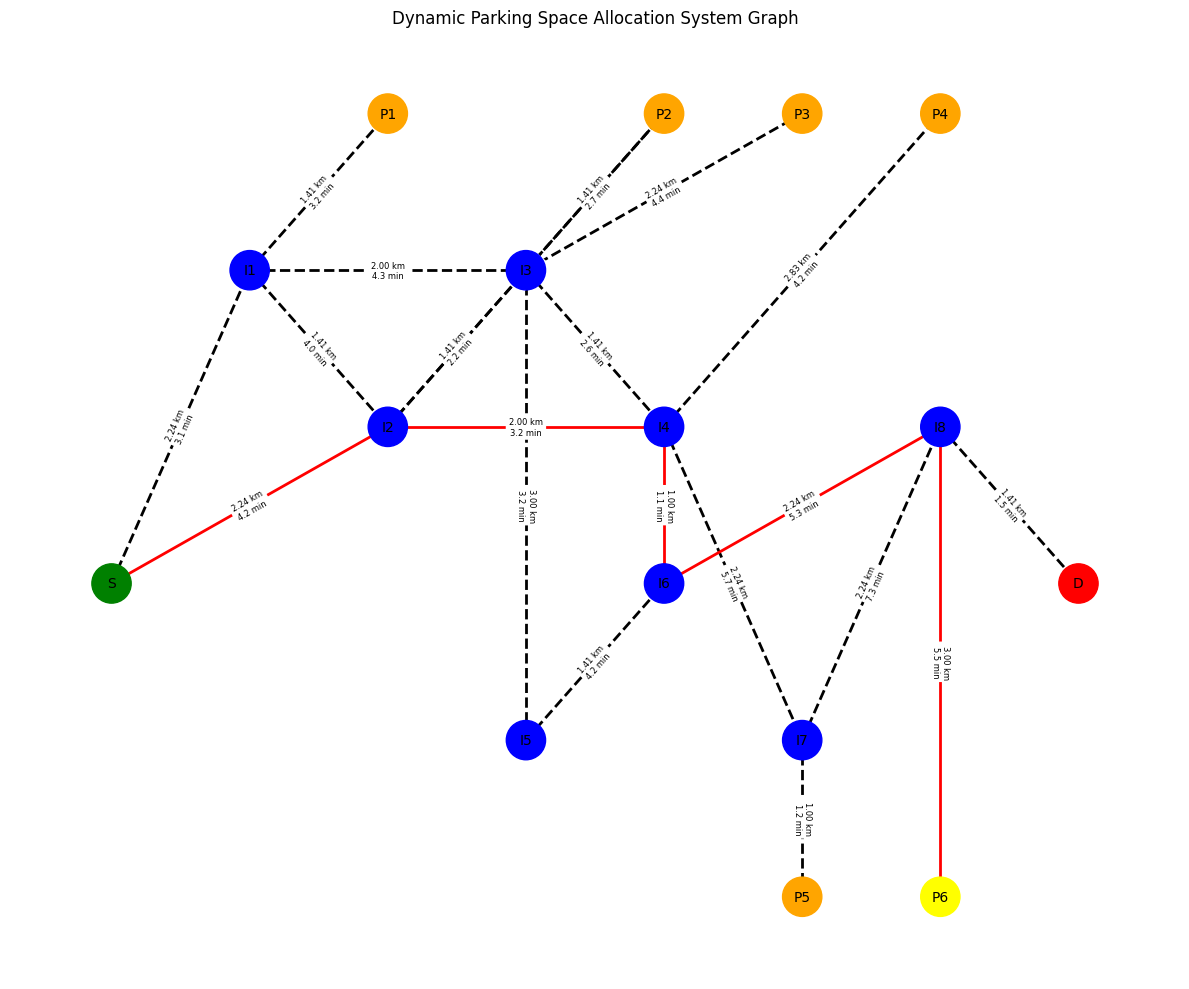


Current node: I2
Path to parking slot: I2 -> I4 -> I6 -> I8 -> P6


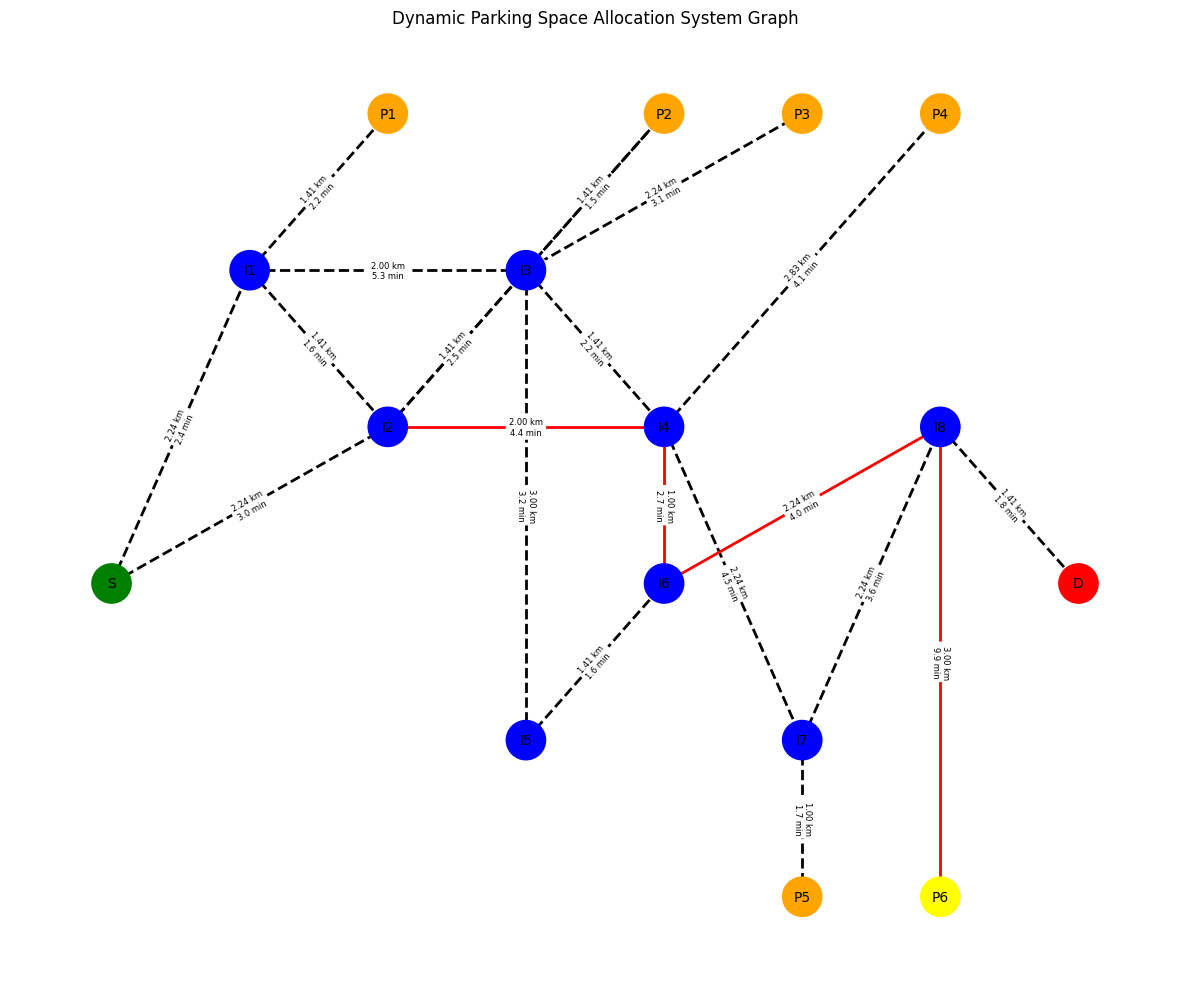

Reached adjacent hex cell of Destination at node I4, so Parking slot P6 has been booked

Current node: I4
Path to parking slot: I4 -> I6 -> I8 -> P6


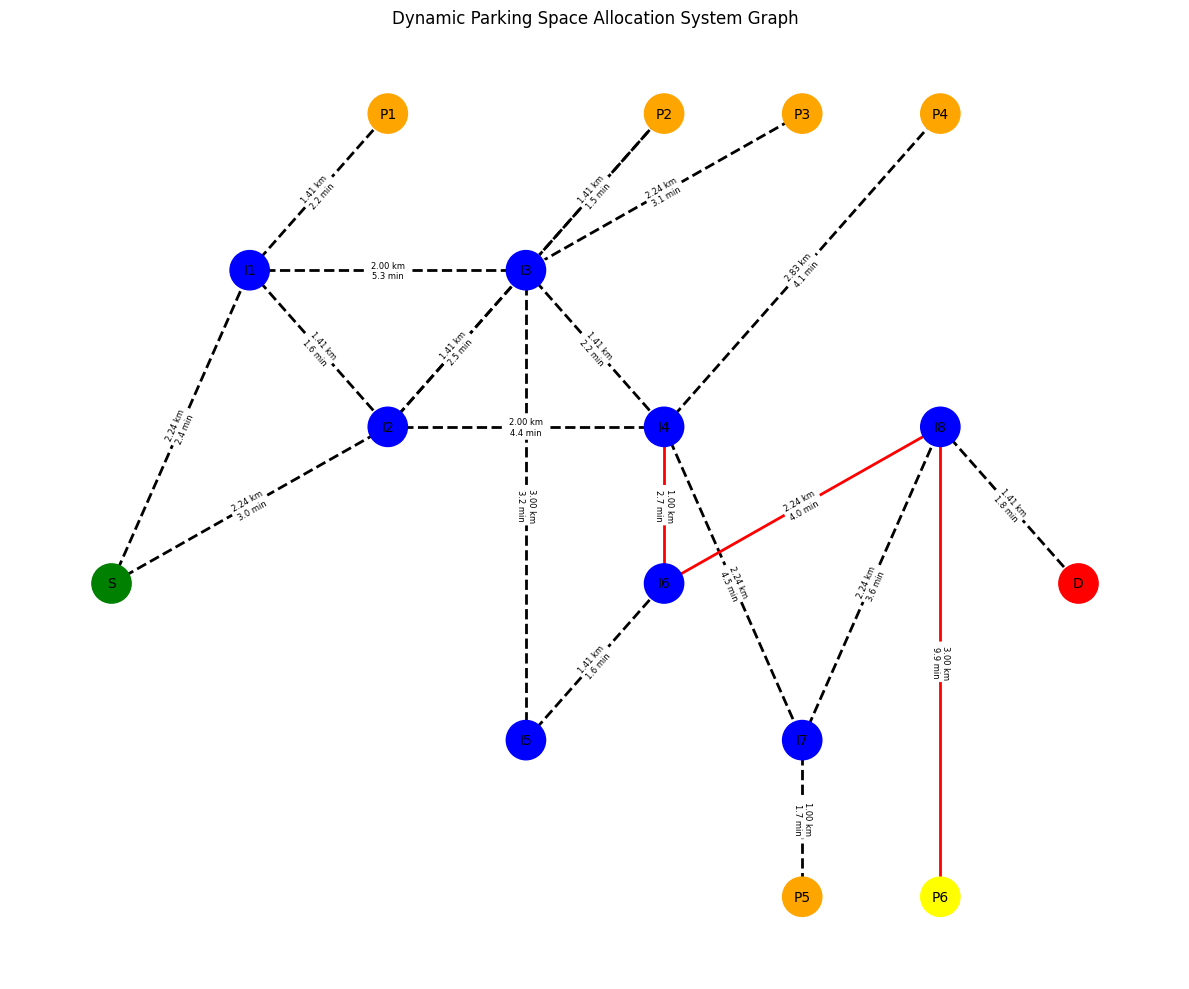


Current node: I6
Path to parking slot: I6 -> I8 -> P6


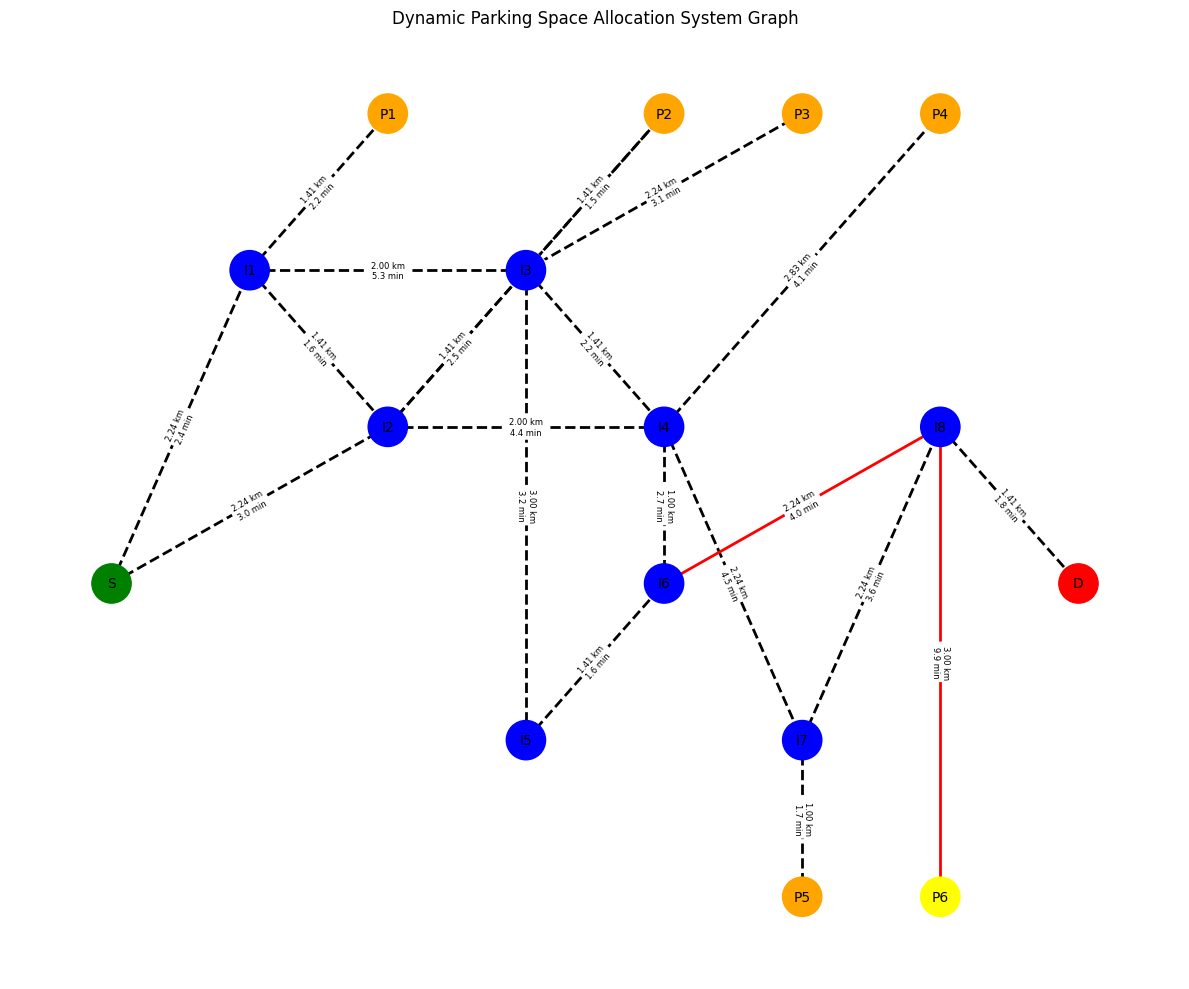


Current node: I8
Path to parking slot: I8 -> P6


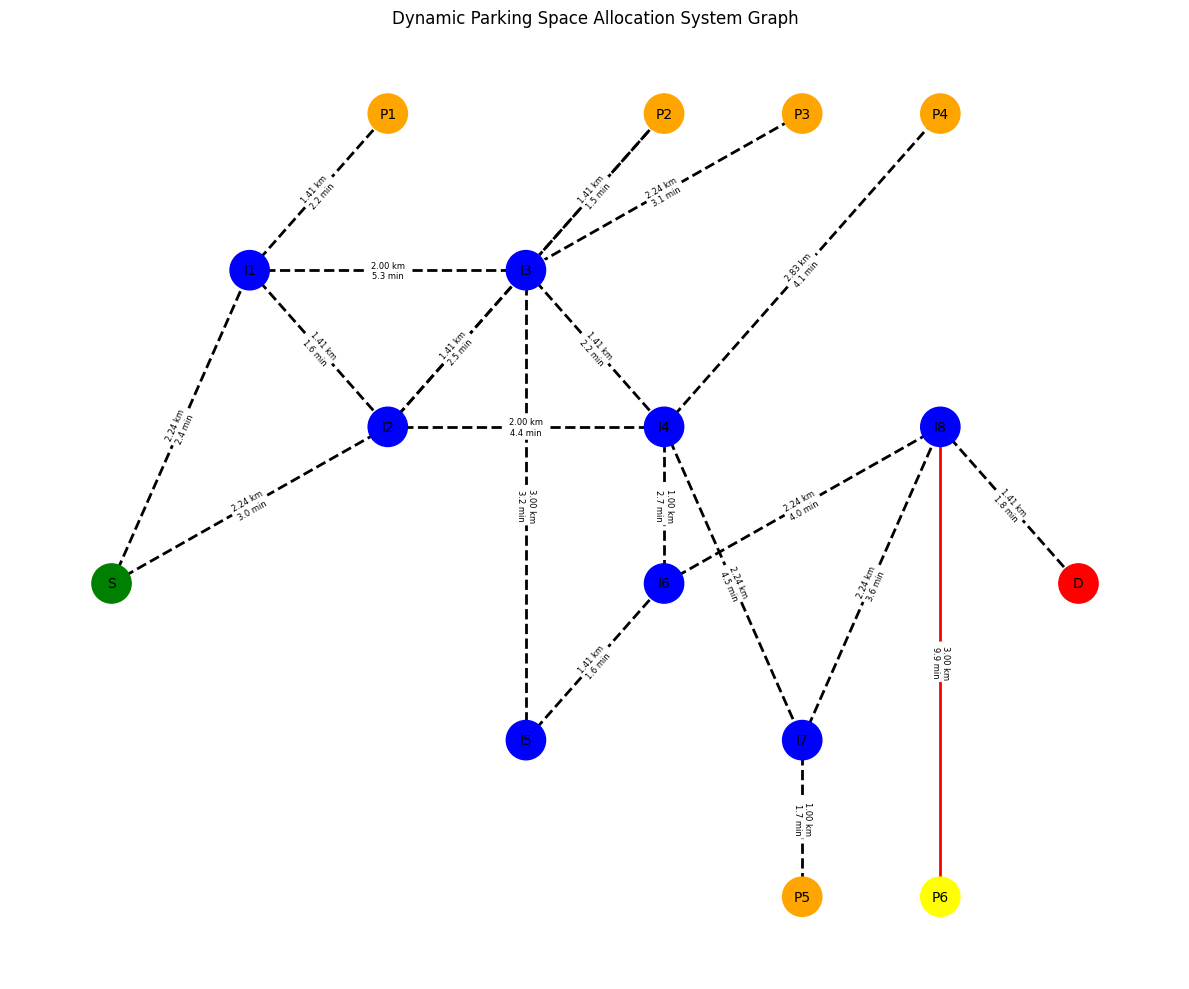


Total travel time to P6: 25.16 minutes
Final Path: S -> I2 -> I4 -> I6 -> I8 -> P6


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import heapq
import random

# Define the nodes with their positions and types
# Nodes represent various points in the system: source, intersections, destination, and parking lots.
nodes = {
    'S': {'pos': (0, 0), 'type': 'source'},  # Source
    'I1': {'pos': (1, 2), 'type': 'intersection'},
    'I2': {'pos': (2, 1), 'type': 'intersection'},
    'I3': {'pos': (3, 2), 'type': 'intersection'},
    'I4': {'pos': (4, 1), 'type': 'intersection'},
    'I5': {'pos': (3, -1), 'type': 'intersection'},
    'I6': {'pos': (4, 0), 'type': 'intersection'},
    'I7': {'pos': (5, -1), 'type': 'intersection'},
    'I8': {'pos': (6, 1), 'type': 'intersection'},
    'D': {'pos': (7, 0), 'type': 'destination'},  # Destination

    # Define parking lots with additional attributes like cost, capacity, and schedule
    'P1': {
        'pos': (2, 3),
        'type': 'parking_lot',
        'parking_slot_id': 'P1',
        'parking_spaces_in_slot': 50,
        'cost': 10,
        'capacity': 100,
        'availability': True,
        'schedule': [(50, 120)]
    },
    'P2': {
        'pos': (4, 3),
        'type': 'parking_lot',
        'parking_slot_id': 'P2',
        'parking_spaces_in_slot': 30,
        'cost': 8,
        'capacity': 80,
        'availability': True,
        'schedule': [(0, 60)]
    },
    'P3': {
        'pos': (5, 3),
        'type': 'parking_lot',
        'parking_slot_id': 'P3',
        'parking_spaces_in_slot': 20,
        'cost': 6,
        'capacity': 60,
        'availability': True,
        'schedule': [(50, 120)]
    },
    'P4': {
        'pos': (6, 3),
        'type': 'parking_lot',
        'parking_slot_id': 'P4',
        'parking_spaces_in_slot': 0,
        'cost': 5,
        'capacity': 50,
        'availability': True,
        'schedule': [(50, 120)]
    },
    'P5': {
        'pos': (5, -2),
        'type': 'parking_lot',
        'parking_slot_id': 'P5',
        'parking_spaces_in_slot': 25,
        'cost': 7,
        'capacity': 70,
        'availability': True,
        'schedule': [(50, 120)]
    },
    'P6': {
        'pos': (6, -2),
        'type': 'parking_lot',
        'parking_slot_id': 'P6',
        'parking_spaces_in_slot': 0,
        'cost': 9,
        'capacity': 65,
        'availability': True,
        'schedule': [(50, 70)]
    },
}

# Create a graph to represent the system
# Nodes will be intersections, parking lots, source, and destination
G = nx.Graph()

# Helper function to assign nodes to hexagonal cells (simplifies distance calculations)
def assign_hex_cell(pos, cell_size=2):
    x, y = pos
    q = int(x // cell_size)
    r = int(y // cell_size)
    return (q, r)

# Add all nodes and their attributes to the graph
for node, attr in nodes.items():
    attr['hex_cell'] = assign_hex_cell(attr['pos'])  # Assign hex cell for better spatial management
    G.add_node(node, **attr)  # Add nodes with attributes

# Define edges representing connections between nodes
# Edges connect intersections, parking lots, and the destination
edges = [
    ('S', 'I1'),
    ('S', 'I2'),
    ('I1', 'I2'),
    ('I1', 'I3'),
    ('I2', 'I3'),
    ('I2', 'I4'),
    ('I3', 'I4'),
    ('I3', 'I5'),
    ('I4', 'I6'),
    ('I5', 'I6'),
    ('I6', 'I8'),
    ('I4', 'I7'),
    ('I7', 'I8'),
    ('I8', 'D'),
    # Connections to parking lots
    ('I1', 'P1'),
    ('I2', 'P2'),
    ('I3', 'P2'),
    ('I3', 'P3'),
    ('I4', 'P4'),
    ('I7', 'P5'),
    ('I8', 'P6'),
]

# Function to calculate the Euclidean distance between two nodes
def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]['pos']
    x2, y2 = nodes[node2]['pos']
    return math.hypot(x2 - x1, y2 - y1)

# Add edges with calculated distances
for edge in edges:
    distance = euclidean_distance(edge[0], edge[1])
    G.add_edge(edge[0], edge[1], distance=distance)

# Initialize the 'time' attribute on edges for traffic simulation
base_speed = 60  # Base speed in km/h

# Update traffic conditions dynamically
def update_traffic(G):
    for u, v, data in G.edges(data=True):
        distance = data['distance']
        traffic_factor = random.uniform(0.3, 1)  # Random traffic factor
        adjusted_speed = max(base_speed * traffic_factor, 0.1)  # Prevent zero speed
        time_minutes = (distance / adjusted_speed) * 60  # Calculate travel time in minutes
        data['time'] = time_minutes

update_traffic(G) # Initialize traffic conditions

# Current time in minutes and desired parking duration
t_current = 50  # Start time in minutes
desired_parking_duration = 60  # Duration in minutes

def get_cells_within_distance(G, target_node, max_distance):
    cells_in_range = set()
    for node in G.nodes():
        distance = euclidean_distance(node, target_node)
        if distance <= max_distance:
            cells_in_range.add(G.nodes[node]['hex_cell'])
    return cells_in_range

# Include hex cells between source and destination
def get_hex_cells_between_nodes(G, start_node, end_node):
    start_cell = G.nodes[start_node]['hex_cell']
    end_cell = G.nodes[end_node]['hex_cell']
    cells_between = set()

    min_q = min(start_cell[0], end_cell[0])
    max_q = max(start_cell[0], end_cell[0])
    min_r = min(start_cell[1], end_cell[1])
    max_r = max(start_cell[1], end_cell[1])

    for q in range(min_q - 1, max_q + 2):
        for r in range(min_r - 1, max_r + 2):
            cells_between.add((q, r))
    return cells_between

hex_cells_in_range = get_cells_within_distance(G, 'D', max_distance=3)

# Helper function to find parking slots within a specific range
def get_available_parking_slots(G, hex_cells=None):
    # Filter by availability and location
    if hex_cells:
        return [
            node for node, attr in G.nodes(data=True)
            if attr['type'] == 'parking_lot' and attr['hex_cell'] in hex_cells and attr['availability']
        ]
    else:
        # Return all available slots if no location constraint
        return [
            node for node, attr in G.nodes(data=True)
            if attr['type'] == 'parking_lot' and attr['availability']
        ]

parking_slots = get_available_parking_slots(G, hex_cells_in_range)

if not parking_slots:
    print("\nNo parking slots available within 3 km from Destination.")
    # Instead of exiting, expand the search to all parking slots
    parking_slots = get_available_parking_slots(G)
    if not parking_slots:
        print("No parking slots available at all.")
        exit()
    else:
        print("Expanding search to all available parking slots.")

# Initialize the priority queue with parking slot preferences
def initialize_parking_queue(parking_slots, G):
    Q_p = []
    for p in parking_slots:
        attr = G.nodes[p]
        distance = euclidean_distance(p, 'D')
        cost = attr['cost']
        priority = (distance, cost) # Priority based on distance and cost
        heapq.heappush(Q_p, (priority, p))
    return Q_p

Q_p = initialize_parking_queue(parking_slots, G)

# Booking a parking slot
def book_parking_slot(Q_p, t_start, t_end):
    while Q_p:
        priority, p = heapq.heappop(Q_p)
        attr = G.nodes[p]
        if not attr['availability']:
            continue  # Skip unavailable slots
        # Check overlap in parking schedule
        k = attr['capacity']
        S_p = attr['schedule']
        # Count overlapping bookings
        n_overlaps = sum(1 for s, e in S_p if not (e <= t_start or s >= t_end))
        if n_overlaps < k:
            S_p.append((t_start, t_end)) # Add booking
            return p
    return None

# Function to cancel a booking
def cancel_booking(parking_slot, t_start, t_end):
    S_p = G.nodes[parking_slot]['schedule']
    G.nodes[parking_slot]['schedule'] = [
        (s, e) for s, e in S_p if not (s == t_start and e == t_end)
    ]

t_start = t_current
t_end = t_start + desired_parking_duration

selected_parking_slot = book_parking_slot(Q_p.copy(), t_start, t_end)

if not selected_parking_slot:
    print("No parking slot available for the desired time.")
    exit()

print(f"\nSelected Parking Slot: {selected_parking_slot}")

# Update hex cells between 'S' and the selected parking slot
hex_cells_between_S_and_P = get_hex_cells_between_nodes(G, 'S', selected_parking_slot)

# Combine hex cells to use in pathfinding
H_cells = hex_cells_in_range.union(hex_cells_between_S_and_P)

u = 'S'  # Current node
Path = [u]  # Path taken
T_total = 0  # Total travel time
destination = selected_parking_slot
current_booking = (t_start, t_end)  # Booking time slot

destination_hex = G.nodes['D']['hex_cell']
def get_adjacent_hex_cells(hex_cell):
    q, r = hex_cell
    # Adjacent hexes in a hex grid (pointy topped or flat topped) - using a simple offset
    # This is a rough approximation: assuming cube coordinates or axial coordinates.
    adjacent_cells = [
        (q+1, r), (q-1, r), (q, r+1), (q, r-1), (q+1, r-1), (q-1, r+1)
    ]
    return adjacent_cells

adjacent_to_destination = set(get_adjacent_hex_cells(destination_hex))
adjacent_zone_reached = False

# Helper function to update parking availability
def update_parking_availability(G, t_current):
    for node, attr in G.nodes(data=True):
        if attr['type'] == 'parking_lot':
            # Remove bookings that have ended
            attr['schedule'] = [(s, e) for s, e in attr['schedule'] if e > t_current]
            # Randomly change availability
            if random.random() < 0.1:  # 10% chance to change
                attr['availability'] = not attr['availability']

# Helper function to find shortest path considering hex grid
def find_shortest_path_in_hex_grid(G, start_node, end_node, H_cells):
    priority_queue = [(0, start_node)]
    distances = {node: float('inf') for node in G.nodes}
    distances[start_node] = 0
    predecessors = {node: None for node in G.nodes}
    visited = set()

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_node == end_node:
            break

        if current_node in visited:
            continue

        visited.add(current_node)

        if G.nodes[current_node]['hex_cell'] not in H_cells:
            continue

        for neighbor in G.neighbors(current_node):
            if G.nodes[neighbor]['hex_cell'] not in H_cells:
                continue

            edge_data = G.get_edge_data(current_node, neighbor)
            weight = edge_data['time']
            distance = current_distance + weight

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    path = []
    node = end_node
    while node:
        path.append(node)
        node = predecessors[node]
    path.reverse()

    return path, distances[end_node]

# Visualization function to display the graph and paths
def visualize_graph(G, Path, selected_parking_slot, t_current):
    pos = {node: nodes[node]['pos'] for node in G.nodes()}

    plt.figure(figsize=(12, 10))
    labels = {node: node for node in G.nodes()}

    node_colors = []
    for node in G.nodes(data=True):
        node_name = node[0]
        node_type = node[1]['type']
        if node_name == selected_parking_slot:
            node_colors.append('yellow')  # Highlight selected parking slot
        elif node_name == 'D':
            node_colors.append('red')
        elif node_type == 'source':
            node_colors.append('green')
        elif node_type == 'intersection':
            node_colors.append('blue')
        elif node_type == 'parking_lot':
            if node[1]['availability']:
                node_colors.append('orange')
            else:
                node_colors.append('gray')  # Indicate unavailable parking slots
        else:
            node_colors.append('gray')

    nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

    # Draw edges with weights
    edge_colors = []
    edge_styles = []
    edges_to_draw = []
    for u_edge, v_edge, data in G.edges(data=True):
        if Path and u_edge in Path and v_edge in Path and abs(Path.index(v_edge) - Path.index(u_edge)) == 1:
            edge_colors.append('red')  # Highlight the path
            edge_styles.append('solid')
        else:
            edge_colors.append('black')
            edge_styles.append('dashed')
        edges_to_draw.append((u_edge, v_edge))

    nx.draw_networkx_edges(
        G, pos,
        edgelist=edges_to_draw,
        width=2,
        edge_color=edge_colors,
        style=edge_styles
    )

    # Draw edge labels showing distance and time
    edge_labels = {}
    for u_edge, v_edge, data in G.edges(data=True):
        distance = data['distance']
        time_minutes = data['time']
        edge_labels[(u_edge, v_edge)] = f"{distance:.2f} km\n{time_minutes:.1f} min"

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    plt.title(f'Dynamic Parking Space Allocation System Graph')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Traverse from S to selected parking slot
try:
    while u != destination:
        if not adjacent_zone_reached:
            update_traffic(G)
            t_current += 1  # Simulate time passing
            update_parking_availability(G, t_current)
        else:
            t_current += 1

        # Check if selected parking slot is still available and we haven't fixed the parking yet
        if not adjacent_zone_reached and not G.nodes[selected_parking_slot]['availability']:
            # Cancel current booking
            cancel_booking(selected_parking_slot, t_start, t_end)
            print(f"Selected parking slot {selected_parking_slot} became unavailable.")

            # Attempt to book the next nearest parking slot
            parking_slots = get_available_parking_slots(G)
            if not parking_slots:
                print("No parking slots available after updates.")
                exit()

            Q_p = initialize_parking_queue(parking_slots, G)
            selected_parking_slot = book_parking_slot(Q_p.copy(), t_current, t_current + desired_parking_duration)
            if not selected_parking_slot:
                print("Failed to book a new parking slot.")
                exit()
            else:
                print(f"Rebooked Parking Slot: {selected_parking_slot}")
                destination = selected_parking_slot
                # Update hex cells between 'u' and new destination
                hex_cells_between_S_and_P = get_hex_cells_between_nodes(G, u, selected_parking_slot)
                H_cells = hex_cells_in_range.union(hex_cells_between_S_and_P)

        # Find shortest path from u to destination within hex cells
        path, travel_time = find_shortest_path_in_hex_grid(G, u, destination, H_cells)
        # Visualize the graph at current state
        print(f"\nCurrent node: {u}")
        print(f"Path to parking slot: {' -> '.join(path)}")
        visualize_graph(G, path, selected_parking_slot, t_current)

        # Move to next node
        if len(path) > 1:
            next_node = path[1]  # Next node after current
            edge_data = G.get_edge_data(u, next_node)
            t_travel = edge_data['time']
            T_total += t_travel
            u = next_node
            Path.append(u)

            # Check if we are now in an adjacent hex cell of D's hex cell
            if G.nodes[u]['hex_cell'] in adjacent_to_destination and not adjacent_zone_reached:
                # Now we fix the parking slot: no more availability updates or slot changes
                print(f"Reached adjacent hex cell of Destination at node {u}, so Parking slot {selected_parking_slot} has been booked")
                adjacent_zone_reached = True
        else:
            break
except nx.NetworkXNoPath:
    print(f"No path found from {u} to {destination}.")
    exit()

print(f"\nTotal travel time to {selected_parking_slot}: {T_total:.2f} minutes")
print(f"Final Path: {' -> '.join(Path)}")